In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
import math

ModuleNotFoundError: No module named 'yfinance'

In [ ]:
data = pd.read_csv("MSFT.csv")
data

In [6]:
data["log_ret"] = np.log(data.Close) - np.log(data.Close.shift(1))
data["RSILR"] =ta.rsi(data.log_ret, length=15)
data["EMAFLR"]=ta.ema(data.log_ret, length=25)
data["EMAMLR"]=ta.ema(data.log_ret, length=100)
data["EMASLR"]=ta.ema(data.log_ret, length=150)
    

data["log_ret_next"] = data["log_ret"].shift(-1)
data.dropna(inplace=True)
data.reset_index(inplace=True)
dates = data["Date"]
data.drop(["Volume", "Close", "Date", "index", "Open", "High", "Low", "Adj Close"], axis=1, inplace=True)
data

,log_ret,RSILR,EMAFLR,EMAMLR,EMASLR,log_ret_next
0,0.015037,50.994754,0.007848,0.002803,0.001204,0.043808
1,0.043808,54.276260,0.010614,0.003615,0.001768,0.000000
2,0.000000,48.930938,0.009798,0.003543,0.001745,0.028169
3,0.028169,52.175763,0.011211,0.004031,0.002094,0.006920
4,0.006920,49.627265,0.010881,0.004088,0.002158,0.040544
...,...,...,...,...,...,...
9316,-0.026482,44.596048,-0.002368,-0.000393,0.000106,0.017617
9317,0.017617,53.682327,-0.000831,-0.000036,0.000338,0.001253
9318,0.001253,50.396331,-0.000671,-0.000011,0.000350,0.024436
9319,0.024436,54.613343,0.001261,0.000473,0.000669,0.007792


In [7]:
from sklearn.preprocessing import MinMaxScaler # as using NN feed model with between 1 or 0
sc = MinMaxScaler(feature_range=(0,1))
data_scaled = sc.fit_transform(data)
print(data_scaled)
pd.DataFrame(data_scaled)

[[0.69525585 0.58454283 0.73646855 0.5860295  0.50466096 0.74883134]
 [0.74883134 0.65774016 0.78608436 0.62794095 0.54250304 0.66725528]
 [0.66725528 0.5385073  0.77143917 0.62424619 0.54093275 0.7197093 ]
 ...
 [0.66958902 0.57119438 0.58366793 0.44080763 0.44741002 0.71275802]
 [0.71275802 0.66525915 0.61830883 0.46579447 0.4688037  0.68176503]
 [0.68176503 0.59048424 0.62732057 0.4732748  0.47513059 0.6591642 ]]


,0,1,2,3,4,5
0,0.695256,0.584543,0.736469,0.586030,0.504661,0.748831
1,0.748831,0.657740,0.786084,0.627941,0.542503,0.667255
2,0.667255,0.538507,0.771439,0.624246,0.540933,0.719709
3,0.719709,0.610886,0.796787,0.649416,0.564403,0.680141
4,0.680141,0.554040,0.790866,0.652369,0.568689,0.742752
...,...,...,...,...,...,...
9316,0.617943,0.441813,0.553217,0.421082,0.431043,0.700061
9317,0.700061,0.644492,0.580792,0.439490,0.446597,0.669589
9318,0.669589,0.571194,0.583668,0.440808,0.447410,0.712758
9319,0.712758,0.665259,0.618309,0.465794,0.468804,0.681765


In [8]:
X = []

backtest = 5
for j in range(5): # number of rows of inputs
    X.append([])
    for i in range(backtest, data_scaled.shape[0]):
        X[j].append(data_scaled[i-backtest:i, j])

#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2])

In [9]:
X, y = np.array(X), np.array(data_scaled[backtest:,-2:-1])
y = np.reshape(y,(len(y),1))
X.shape #9316 rows of 5 days of 8 inputs

(9316, 5, 5)

In [10]:
q_80 = round(int(X.shape[0]) * 0.8)
q_90 = round(int(X.shape[0]) * 0.9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

In [13]:
def adapt_learning_rate(epoch):
    if epoch <= 10:
        return 0.001
    else:
        return 0.0001
from tensorflow.keras.callbacks import ModelCheckpoint
my_lr_scheduler = tf.keras.callbacks.LearningRateScheduler(adapt_learning_rate)

In [21]:
import tensorflow as tf
import keras
from keras.optimizers import Adam, RMSprop
from keras.callbacks import History
from keras.models import Model
from keras import layers
from keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

cp = ModelCheckpoint("stationary/", save_best_only=True)
model = Sequential([layers.Input((backtest, 5), name="input"),
                    layers.LSTM(150),
                    layers.Dense(1, name = "Dense_layer"),
                    layers.Activation("linear", name = "output")])

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse')
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks = [my_lr_scheduler, cp])

Epoch 1/20
225/233 [===========================>..] - ETA: 0s - loss: 0.0038INFO:tensorflow:Assets written to: stationary\assets


INFO:tensorflow:Assets written to: stationary\assets


233/233 [==============================] - 6s 16ms/step - loss: 0.0038 - val_loss: 1.8869e-04 - lr: 0.0010
Epoch 2/20
233/233 [==============================] - 1s 5ms/step - loss: 0.0014 - val_loss: 0.0015 - lr: 0.0010
Epoch 3/20
227/233 [============================>.] - ETA: 0s - loss: 0.0010INFO:tensorflow:Assets written to: stationary\assets


INFO:tensorflow:Assets written to: stationary\assets


233/233 [==============================] - 3s 14ms/step - loss: 0.0011 - val_loss: 1.4345e-04 - lr: 0.0010
Epoch 4/20
233/233 [==============================] - 1s 5ms/step - loss: 9.4973e-04 - val_loss: 0.0010 - lr: 0.0010
Epoch 5/20
233/233 [==============================] - 1s 5ms/step - loss: 8.3488e-04 - val_loss: 4.9017e-04 - lr: 0.0010
Epoch 6/20
233/233 [==============================] - 1s 5ms/step - loss: 7.8349e-04 - val_loss: 1.6731e-04 - lr: 0.0010
Epoch 7/20
233/233 [==============================] - 1s 5ms/step - loss: 7.3389e-04 - val_loss: 1.5471e-04 - lr: 0.0010
Epoch 8/20
233/233 [==============================] - 1s 5ms/step - loss: 7.0680e-04 - val_loss: 4.5808e-04 - lr: 0.0010
Epoch 9/20
233/233 [==============================] - 1s 5ms/step - loss: 6.7441e-04 - val_loss: 6.0050e-04 - lr: 0.0010
Epoch 10/20
233/233 [==============================] - 1s 5ms/step - loss: 6.5693e-04 - val_loss: 3.0916e-04 - lr: 0.0010
Epoch 11/20
233/233 [============================

In [22]:
train_predictions = model.predict(X_train).flatten()
val_predictions = model.predict(X_val).flatten()
test_predictions = model.predict(X_test).flatten()

30/30 [==============================] - 0s 2ms/step


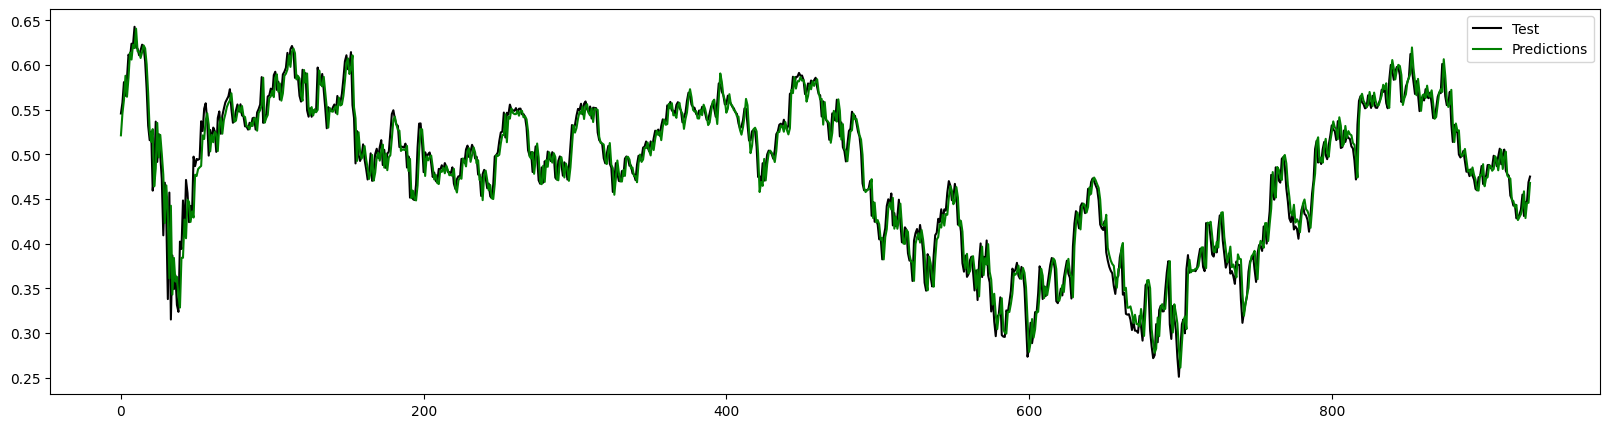

In [23]:
plt.figure(figsize=(20,5))
plt.plot(y_test, color = "black", label = "Test")
plt.plot(test_predictions, color = "green", label = "Predictions")
plt.legend()
plt.show()

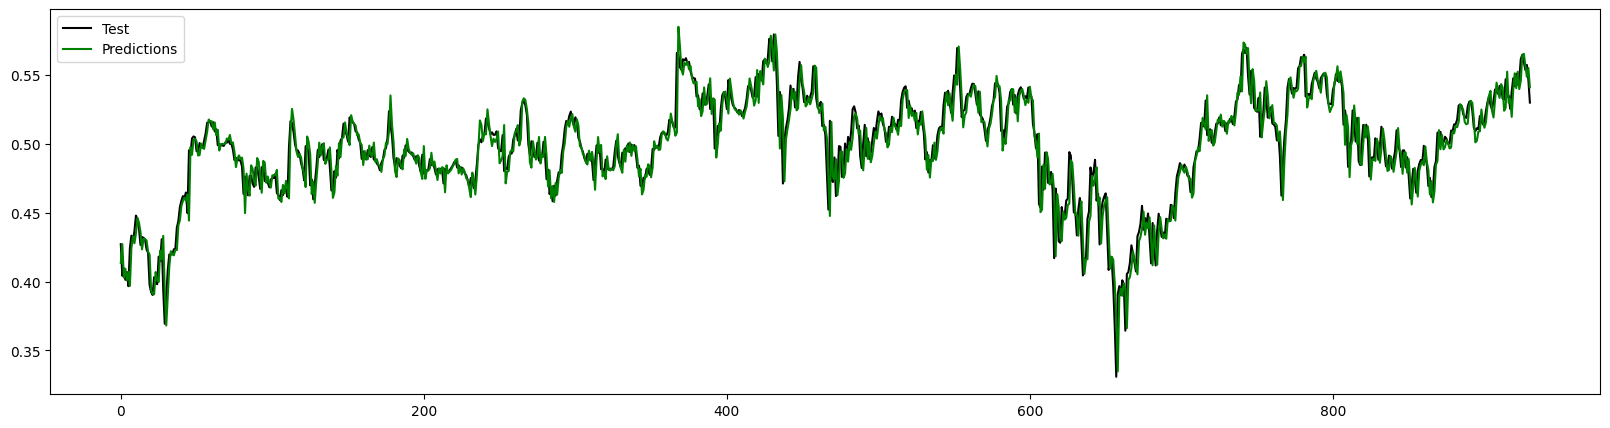

In [24]:
plt.figure(figsize=(20,5))
plt.plot(y_val, color = "black", label = "Test")
plt.plot(val_predictions, color = "green", label = "Predictions")
plt.legend()
plt.show()

In [17]:
dates_test = dates_test.iloc[:-5]

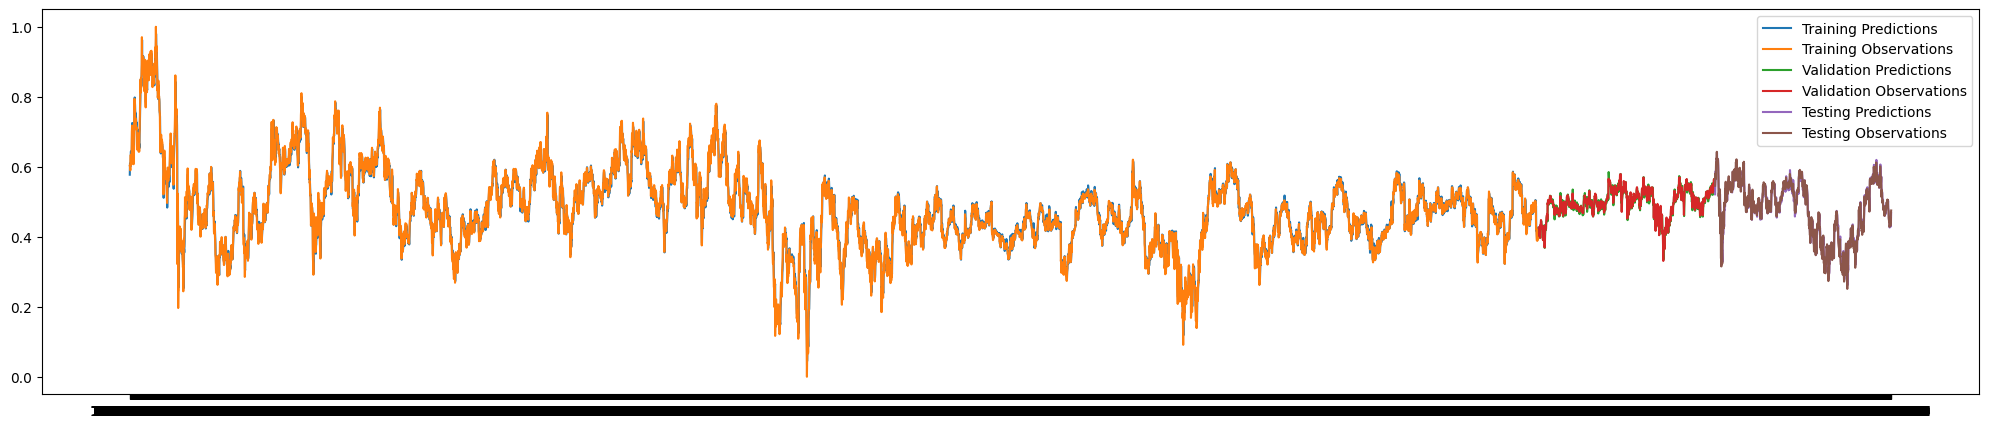

In [26]:
plt.figure(figsize=(25,5))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [ ]:
from keras.models import load_model

filename = "Stationary"
model = load_model(filename)